# Tensorflow2 KeyNotes
### ==== Time Series Analysis with Deep Neural Network (TF2) ====
### Instructions

These serial notebooks are intended to record my practicing and keynotes with deep learning in the framework of TensorFlow 2. Within these notebooks, I demonstrate the networks with specific examples and my personal interpretations.  You can find instructions in each section for each project.  Feel free to refer to it if is helpful for your work. 

In this notebook, I demonstrate the basic tasks of time series analysis by using neural network: 
1. time series forecasting by using neural network
2. time series forecasting by using recurrent neural network
3. time series forecasting by using convolutional neural network

### Code by Hao, Zhao, Aug, 2020.



In [1]:
## Import the tensorflow library

In [2]:
import tensorflow as tf
print(tf.__version__)


2.2.0



###  Load the diabetes dataset and preprocess the dataset 

In [3]:
import tensorflow as tf
import numpy as np
# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.fftpack

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout,Conv1D


### Generate a synthetic time series based on sinusoid signals



In [4]:
dt,t_min,t_max = 0.001,0,20 
t              = np.linspace(t_min,t_max,int((t_max-t_min)/dt+1))
f0,f1,f2       = 30,100,200
SNR            = 20       
syn_sig        = np.sin((2*np.pi*f0)*t)  + np.sin((2*np.pi*f1)*t) + np.sin((2*np.pi*f2)*t)  
syn_data       = syn_sig + np.random.normal(0,10**(-SNR/20),len(syn_sig))


### plot the partial of generated series

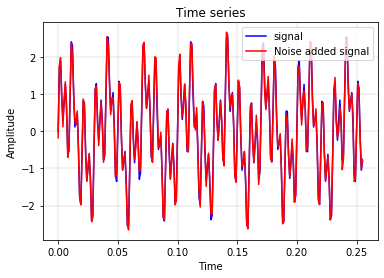

In [5]:

#set the samples to display
N=256

plt.figure(0)
plt.plot(t[0:N],syn_sig[0:N],'b',label='signal')
plt.plot(t[0:N],syn_data[0:N],'r',label='Noise added signal') 
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Time series')
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()


### Time-frequency analysis of generated time series

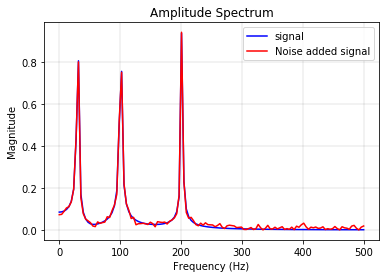

In [6]:
fft_syn_data = scipy.fftpack.fft(syn_data[0:N])
fft_syn_sig = scipy.fftpack.fft(syn_sig[0:N])

# 0 to Fs/2, Fs = 1/Ts
xf = np.linspace(0.0, 1.0/(2*dt), int(N/2))
plt.figure(1)
plt.plot(xf, 2.0/N * np.abs(fft_syn_sig[:N//2]),'b',label='signal')
plt.plot(xf, 2.0/N * np.abs(fft_syn_data[:N//2]),'r',label='Noise added signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Amplitude Spectrum')
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()


### Data preprocessing for neural network training and testing

In [7]:

# define the function for datasets generation 

def dataset_generation(time_series,batch_size,window_step,predict_step):
    
    # derive the total batch numbers
    n_batch = ((len(t))-batch_size)//window_step + 1
    
    # derive the datasets: input (x) and tartget (y)
    dataset_x     = []
    dataset_y     = []    
    train_set_x   = []
    train_set_y   = []
    test_set_x    = []
    test_set_y    = []
    
    # loop through the time series and gernerate the data
    for n in np.arange(1,n_batch+1):
        
        data_batch = time_series[(0+(n-1)*window_step):(batch_size+(n-1)*window_step)] 
        data_x     = data_batch[0:batch_size-predict_step]
        data_y     = data_batch[batch_size-predict_step:batch_size]
    
        dataset_x  = np.concatenate((dataset_x, data_x))
        dataset_y  = np.concatenate((dataset_y, data_y))
        
    # reshape datasets to 2d dimension: batch x dataset
    dataset_x = np.reshape(dataset_x, newshape=(n_batch,len(data_x)))
    dataset_y = np.reshape(dataset_y, newshape=(n_batch,len(data_y)))
    
    # split the dataset into train 80% and test sets (20%)
    train_samples  = int(len(dataset_x) * 0.8) 

    train_set_x = dataset_x[:train_samples,:]
    train_set_y = dataset_y[:train_samples,:]

    test_set_x  = dataset_x[train_samples:,:]
    test_set_y  = dataset_y[train_samples:,:] 
        
    return train_set_x,train_set_y,test_set_x,test_set_y
    

# generate the datasets 
batch_size   = 256
window_step  = batch_size//8
predict_step = 10

train_set_x,train_set_y,test_set_x,test_set_y = dataset_generation(syn_data,batch_size,window_step,predict_step)

print('train_set_x: has shape {}'.format(train_set_x.shape))
print('train_set_y: has shape {}'.format(train_set_y.shape))
print('test_set_x: has shape {}'.format(test_set_x.shape))
print('test_set_y: has shape {}'.format(test_set_y.shape))



train_set_x: has shape (494, 246)
train_set_y: has shape (494, 10)
test_set_x: has shape (124, 246)
test_set_y: has shape (124, 10)


### Build the dense neural network 

In [8]:
model = Sequential([Dense(32, activation='relu',input_shape=(batch_size-predict_step,)),
                    Dropout(0.1),
                    Dense(16,activation='relu'),
                    Dropout(0.1),
                    Dense(predict_step)
                    ])

model.compile(optimizer=tf.keras.optimizers.RMSprop(),loss='mse',metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                7904      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 8,602
Trainable params: 8,602
Non-trainable params: 0
_________________________________________________________________


### Train the dense neural network

In [9]:
history = model.fit(train_set_x,train_set_y,epochs=300,validation_split=0.10,verbose=1)


Epoch 1/300
14/14 [==============================] - 0s 9ms/step - loss: 1.5703 - mae: 0.9900 - val_loss: 0.9118 - val_mae: 0.7672
Epoch 2/300
14/14 [==============================] - 0s 3ms/step - loss: 0.9540 - mae: 0.7776 - val_loss: 0.7074 - val_mae: 0.6615
Epoch 3/300
14/14 [==============================] - 0s 3ms/step - loss: 0.8030 - mae: 0.7056 - val_loss: 0.5578 - val_mae: 0.5762
Epoch 4/300
14/14 [==============================] - 0s 2ms/step - loss: 0.7084 - mae: 0.6590 - val_loss: 0.4800 - val_mae: 0.5348
Epoch 5/300
14/14 [==============================] - 0s 3ms/step - loss: 0.6389 - mae: 0.6270 - val_loss: 0.4087 - val_mae: 0.4935
Epoch 6/300
14/14 [==============================] - 0s 3ms/step - loss: 0.5663 - mae: 0.5897 - val_loss: 0.3408 - val_mae: 0.4520
Epoch 7/300
14/14 [==============================] - 0s 3ms/step - loss: 0.5258 - mae: 0.5610 - val_loss: 0.2879 - val_mae: 0.4169
Epoch 8/300
14/14 [==============================] - 0s 2ms/step - loss: 0.4633 - m

14/14 [==============================] - 0s 3ms/step - loss: 0.1602 - mae: 0.2889 - val_loss: 0.0390 - val_mae: 0.1568
Epoch 64/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1553 - mae: 0.2844 - val_loss: 0.0449 - val_mae: 0.1651
Epoch 65/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1436 - mae: 0.2737 - val_loss: 0.0412 - val_mae: 0.1604
Epoch 66/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1431 - mae: 0.2749 - val_loss: 0.0356 - val_mae: 0.1529
Epoch 67/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1611 - mae: 0.2917 - val_loss: 0.0365 - val_mae: 0.1542
Epoch 68/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1526 - mae: 0.2812 - val_loss: 0.0341 - val_mae: 0.1503
Epoch 69/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1654 - mae: 0.2911 - val_loss: 0.0314 - val_mae: 0.1440
Epoch 70/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1522 - mae: 0

Epoch 125/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1291 - mae: 0.2560 - val_loss: 0.0287 - val_mae: 0.1370
Epoch 126/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1464 - mae: 0.2733 - val_loss: 0.0256 - val_mae: 0.1264
Epoch 127/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1260 - mae: 0.2501 - val_loss: 0.0322 - val_mae: 0.1445
Epoch 128/300
14/14 [==============================] - 0s 2ms/step - loss: 0.1182 - mae: 0.2437 - val_loss: 0.0253 - val_mae: 0.1279
Epoch 129/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1325 - mae: 0.2633 - val_loss: 0.0277 - val_mae: 0.1315
Epoch 130/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1343 - mae: 0.2613 - val_loss: 0.0255 - val_mae: 0.1256
Epoch 131/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1291 - mae: 0.2566 - val_loss: 0.0296 - val_mae: 0.1335
Epoch 132/300
14/14 [==============================] - 0s 3ms/step - 

14/14 [==============================] - 0s 3ms/step - loss: 0.1313 - mae: 0.2520 - val_loss: 0.0293 - val_mae: 0.1396
Epoch 187/300
14/14 [==============================] - 0s 2ms/step - loss: 0.1307 - mae: 0.2503 - val_loss: 0.0214 - val_mae: 0.1167
Epoch 188/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1213 - mae: 0.2449 - val_loss: 0.0267 - val_mae: 0.1316
Epoch 189/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1242 - mae: 0.2458 - val_loss: 0.0203 - val_mae: 0.1132
Epoch 190/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1040 - mae: 0.2297 - val_loss: 0.0195 - val_mae: 0.1117
Epoch 191/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1293 - mae: 0.2543 - val_loss: 0.0228 - val_mae: 0.1205
Epoch 192/300
14/14 [==============================] - 0s 2ms/step - loss: 0.1237 - mae: 0.2473 - val_loss: 0.0229 - val_mae: 0.1200
Epoch 193/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1312 -

Epoch 248/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1196 - mae: 0.2392 - val_loss: 0.0197 - val_mae: 0.1139
Epoch 249/300
14/14 [==============================] - 0s 2ms/step - loss: 0.1179 - mae: 0.2421 - val_loss: 0.0212 - val_mae: 0.1159
Epoch 250/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1248 - mae: 0.2510 - val_loss: 0.0226 - val_mae: 0.1200
Epoch 251/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1121 - mae: 0.2334 - val_loss: 0.0213 - val_mae: 0.1174
Epoch 252/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1144 - mae: 0.2384 - val_loss: 0.0163 - val_mae: 0.1041
Epoch 253/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1286 - mae: 0.2514 - val_loss: 0.0201 - val_mae: 0.1126
Epoch 254/300
14/14 [==============================] - 0s 3ms/step - loss: 0.1056 - mae: 0.2329 - val_loss: 0.0236 - val_mae: 0.1232
Epoch 255/300
14/14 [==============================] - 0s 3ms/step - 

# Plot the training and validation loss


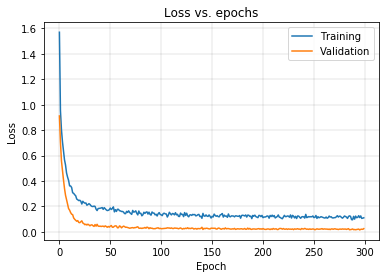

In [10]:
plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()


### Prediction with trainned network


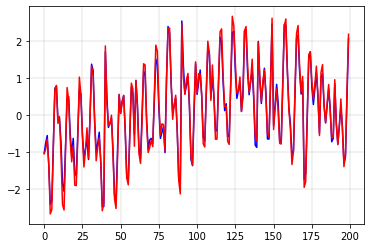

====== Signal to Noise ratio of the prediction based on dense neural network: 17.656272850603976
====== Mean Square Error of the prediction based on dense neural network: 0.02588353911069981


In [11]:
dnn_predictions = model.predict(test_set_x)
dnn_err         = dnn_predictions - test_set_y

plt.figure(3)
plt.plot(dnn_predictions[:20,:].flatten(),'b')
plt.plot(test_set_y[:20,:].flatten(),'r')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

dnn_mse    = 10*np.log10(np.mean(pow(np.abs(dnn_err),2)))
dnn_sigpow = 10*np.log10(np.mean(pow(np.abs(test_set_y),2)))


print("====== Signal to Noise ratio of the prediction based on dense neural network:", dnn_sigpow - dnn_mse)
print("====== Mean Square Error of the prediction based on dense neural network:", np.mean(tf.keras.losses.mean_squared_error(dnn_predictions,test_set_y)))
